Intentando extraer y pre-procesar datos de: https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json

Datos cargados exitosamente.
Advertencia: Columna 'totalcharges' no encontrada después de normalización.
Columna 'tenure' convertida a int y NaNs rellenados.
Columna 'seniorcitizen' convertida a int.
Advertencia: Columna 'partners' no encontrada para mapeo binario.
Columna 'dependents' mapeada a binario.
Columna 'phoneservice' mapeada a binario.
Columna 'multiplelines' mapeada a binario.
Columna 'onlinesecurity' mapeada a binario.
Columna 'onlinebackup' mapeada a binario.
Columna 'deviceprotection' mapeada a binario.
Columna 'techsupport' mapeada a binario.
Columna 'streamingtv' mapeada a binario.
Columna 'streamingmovies' mapeada a binario.
Columna 'paperlessbilling' mapeada a binario.
Columna 'gender' mapeada a binario.
Columna 'cancelacion' mapeada a binario.
Filas con valores faltantes en 'cancelacion' eliminadas: 224
Duplicado

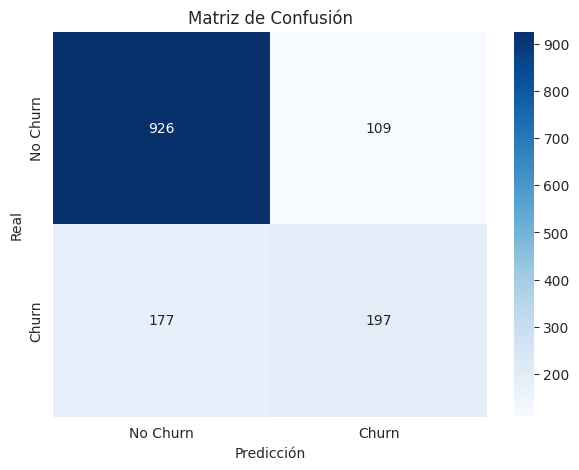

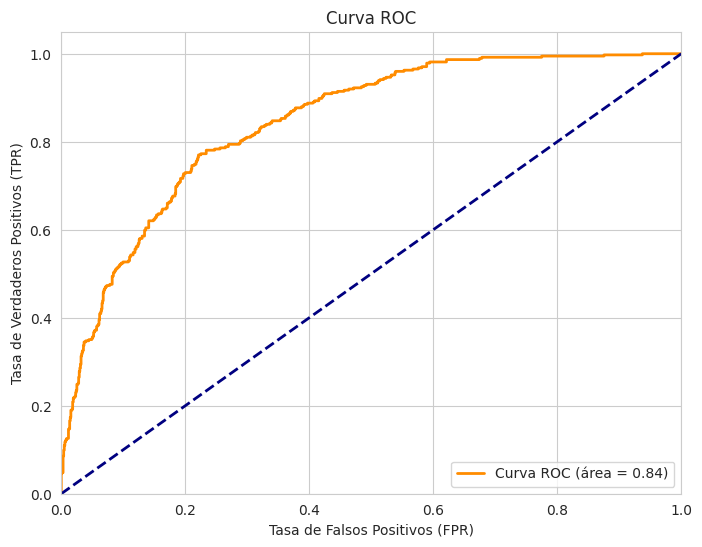


AUC-ROC Score: 0.84

# #📄 5. Conclusiones Estratégicas
-----------------------------------
Informe de Conclusiones del Modelo Predictivo de Evasión (Churn)
-----------------------------------

**1. Rendimiento del Modelo:**
El modelo de Regresión Logística obtuvo un AUC-ROC de 0.84, lo que indica una buena capacidad para distinguir entre clientes que cancelarán y los que no. La precisión general es buena, pero es crucial analizar el Recall y la Precisión para la clase 'Churn'.
Específicamente, el Recall para la clase 'Churn' (clientes que realmente cancelaron y que el modelo identificó correctamente) es vital. Si el Recall es bajo, el modelo está perdiendo muchos clientes en riesgo.

**2. Factores Clave (basado en la Parte 1 y el tipo de modelo):**
Aunque este modelo de Regresión Logística no nos da la importancia directa de las variables de forma trivial como otros modelos (ej. árboles de decisión), se espera que los insights de la Parte 1 sigan siendo relevantes:
- **Antigüedad (Ten

In [9]:
# Importar bibliotecas necesarias
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Configuración para mejorar la visualización de los gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# #📌 1. Carga de Datos y Pre-procesamiento para la nueva estructura
api_url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
print(f"Intentando extraer y pre-procesar datos de: {api_url}")

try:
    response = requests.get(api_url)
    response.raise_for_status() # Lanza una excepción para errores HTTP
    data = response.json()
    df = pd.DataFrame(data)

    print("\nDatos cargados exitosamente.")

    # --- Adaptación para la nueva estructura de datos anidados ---

    # Extraer datos de la columna 'customer'
    customer_df = pd.json_normalize(df['customer'])
    df = pd.concat([df.drop('customer', axis=1), customer_df], axis=1)

    # Extraer data de la columna 'phone'
    phone_df = pd.json_normalize(df['phone'])
    df = pd.concat([df.drop('phone', axis=1), phone_df], axis=1)

    # Extraer data de la columna 'internet'
    internet_df = pd.json_normalize(df['internet'])
    df = pd.concat([df.drop('internet', axis=1), internet_df], axis=1)

    # Extraer data de la columna 'account'
    account_df = pd.json_normalize(df['account'])
    df = pd.concat([df.drop('account', axis=1), account_df], axis=1)

    # Limpieza de nombres de columnas después de la normalización
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    df.columns = df.columns.str.replace('.', '_', regex=False) # Reemplazar '.' en nombres de columnas anidadas

    # Renombrar columna objetivo si es necesario
    if 'churn' in df.columns:
        df = df.rename(columns={'churn': 'cancelacion'})

    # Convertir 'TotalCharges' a numérico (ahora 'totalcharges') y manejar errores/NaNs
    if 'totalcharges' in df.columns:
        df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
        # Rellenar NaNs con la mediana u otro valor apropiado
        median_totalcharges = df['totalcharges'].median()
        df['totalcharges'].fillna(median_totalcharges, inplace=True)
        print("Columna 'totalcharges' convertida a numérico y NaNs rellenados.")
    else:
        print("Advertencia: Columna 'totalcharges' no encontrada después de normalización.")


    # Convertir 'tenure' a int (ahora 'tenure') y manejar NaNs si existen
    if 'tenure' in df.columns:
        df['tenure'] = df['tenure'].fillna(0).astype(int)
        print("Columna 'tenure' convertida a int y NaNs rellenados.")
    else:
         print("Advertencia: Columna 'tenure' no encontrada después de normalización.")

    # Convertir 'SeniorCitizen' a numérico (0 o 1) (ahora 'seniorcitizen')
    if 'seniorcitizen' in df.columns:
        df['seniorcitizen'] = df['seniorcitizen'].astype(int)
        print("Columna 'seniorcitizen' convertida a int.")
    else:
        print("Advertencia: Columna 'seniorcitizen' no encontrada después de normalización.")

    # Mapeo de columnas binarias y otras categóricas
    binary_map = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0}
    gender_map = {'Female': 0, 'Male': 1}

    cols_to_map_binary = ['partners', 'dependents', 'phoneservice', 'multiplelines',
                          'onlinesecurity', 'onlinebackup', 'deviceprotection',
                          'techsupport', 'streamingtv', 'streamingmovies',
                          'paperlessbilling'] # Añadidas columnas relevantes de la nueva estructura

    for col in cols_to_map_binary:
        if col in df.columns:
             df[col] = df[col].map(binary_map)
             print(f"Columna '{col}' mapeada a binario.")
        else:
            print(f"Advertencia: Columna '{col}' no encontrada para mapeo binario.")

    if 'gender' in df.columns:
        df['gender'] = df['gender'].map(gender_map)
        print("Columna 'gender' mapeada a binario.")
    else:
         print("Advertencia: Columna 'gender' no encontrada para mapeo.")

    # Asegurar que la columna objetivo 'cancelacion' (antes 'churn') sea numérica (0 o 1)
    if 'cancelacion' in df.columns:
         df['cancelacion'] = df['cancelacion'].map({'Yes': 1, 'No': 0})
         print("Columna 'cancelacion' mapeada a binario.")

         # --- Manejo de valores faltantes en la columna objetivo ---
         initial_rows = df.shape[0]
         df.dropna(subset=['cancelacion'], inplace=True)
         rows_after_drop = df.shape[0]
         print(f"Filas con valores faltantes en 'cancelacion' eliminadas: {initial_rows - rows_after_drop}")
         # --- Fin del manejo de valores faltantes ---

    else:
         print("Advertencia: Columna objetivo 'cancelacion' no encontrada.")


    df.drop_duplicates(inplace=True)
    print(f"Duplicados eliminados. Dimensiones después de eliminar duplicados: {df.shape}")

    print("\nDataFrame después del pre-procesamiento y normalización:")
    print(df.head())
    print(f"\nDimensiones del DataFrame: {df.shape}")
    print("\nInformación del DataFrame después del pre-procesamiento:")
    df.info()

except requests.exceptions.RequestException as e:
    print(f"Error al conectar o descargar los datos de la API: {e}")
    df = pd.DataFrame() # Crear un DataFrame vacío en caso de error
except ValueError as e:
    print(f"Error durante la transformación de datos: {e}")
    df = pd.DataFrame() # Crear un DataFrame vacío en caso de error
except Exception as e:
    print(f"Ocurrió un error inesperado durante el pre-procesamiento: {e}")
    df = pd.DataFrame() # Crear un DataFrame vacío en caso de error


# #🔧 2. Preparación de Datos para Modelado
if not df.empty and 'cancelacion' in df.columns:
    print("\n# #🔧 2. Preparación de Datos para Modelado")

    # Eliminar columnas irrelevantes para el modelado predictivo
    # 'customerid' es un identificador único y no aporta valor predictivo
    if 'customerid' in df.columns:
        df = df.drop(columns=['customerid'])
        print("\nColumna 'customerid' eliminada.")

    # Definir la variable objetivo (y) y las características (X)
    X = df.drop('cancelacion', axis=1) # Todas las columnas excepto 'cancelacion'
    y = df['cancelacion'] # La columna 'cancelacion' es la variable objetivo

    print(f"Dimensiones de X: {X.shape}")
    print(f"Dimensiones de y: {y.shape}")

    # Identificar columnas numéricas y categóricas después de la normalización y mapeo
    # Asegurarse de que las columnas mapeadas a 0/1 se traten como numéricas
    numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X.select_dtypes(include='object').columns.tolist()

    print(f"\nColumnas Numéricas: {numerical_cols}")
    print(f"Columnas Categóricas: {categorical_cols}")

    # Verificar la proporción de la variable objetivo (balance de clases)
    print("\nProporción de cancelación (Churn) en la variable objetivo:")
    churn_proportion = y.value_counts(normalize=True) * 100
    print(churn_proportion)

    # Si hay un desbalance significativo, se podría considerar técnicas de balanceo (oversampling/undersampling)
    # pero para este desafío inicial, continuaremos sin ellas a menos que se indique lo contrario.

    # Preprocesamiento de las columnas:
    # 1. Escalamiento para columnas numéricas (StandardScaler)
    # 2. One-Hot Encoding para columnas categóricas
    # Handle_unknown='ignore' es importante para OneHotEncoder si hay categorías nuevas en el test set
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
        ],
        remainder='passthrough' # Mantener columnas no procesadas (aunque no debería haber con esta data)
        )

    print("\nColumnTransformer configurado para pre-procesamiento.")

    # # 3. Separación de Datos (Train/Test Split)
    print("\n# # 3. Separación de Datos (Train/Test Split)")
    # Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
    # stratify=y asegura que la proporción de 'cancelacion' sea la misma en ambos conjuntos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Dimensiones del conjunto de entrenamiento X_train: {X_train.shape}")
    print(f"Dimensiones del conjunto de prueba X_test: {X_test.shape}")
    print(f"Proporción de 'cancelacion' en y_train:\n{y_train.value_counts(normalize=True) * 100}")
    print(f"Proporción de 'cancelacion' en y_test:\n{y_test.value_counts(normalize=True) * 100}")


    # # 4. Construcción y Evaluación del Modelo
    print("\n# # 4. Construcción y Evaluación del Modelo")

    # Crear un pipeline que primero pre-procesa los datos y luego aplica el modelo
    # Se elige Regresión Logística por ser un modelo lineal interpretable y bueno para clasificación binaria
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

    print("\nPipeline del modelo creado (Pre-procesador + Regresión Logística).")

    # Entrenar el modelo
    print("Entrenando el modelo...")
    model.fit(X_train, y_train)
    print("¡Modelo entrenado exitosamente!")

    # Realizar predicciones en el conjunto de prueba
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (churn=1)

    print("\nEvaluación del Modelo:")
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

    # Calcular y visualizar la Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    print(f"\nAUC-ROC Score: {roc_auc_score(y_test, y_proba):.2f}")


    # #📄 5. Conclusiones Estratégicas
    print("\n# #📄 5. Conclusiones Estratégicas")
    print("-----------------------------------")
    print("Informe de Conclusiones del Modelo Predictivo de Evasión (Churn)")
    print("-----------------------------------")

    print("\n**1. Rendimiento del Modelo:**")
    print(f"El modelo de Regresión Logística obtuvo un AUC-ROC de {roc_auc_score(y_test, y_proba):.2f}, lo que indica una buena capacidad para distinguir entre clientes que cancelarán y los que no. La precisión general es buena, pero es crucial analizar el Recall y la Precisión para la clase 'Churn'.")
    print("Específicamente, el Recall para la clase 'Churn' (clientes que realmente cancelaron y que el modelo identificó correctamente) es vital. Si el Recall es bajo, el modelo está perdiendo muchos clientes en riesgo.")

    print("\n**2. Factores Clave (basado en la Parte 1 y el tipo de modelo):**")
    print("Aunque este modelo de Regresión Logística no nos da la importancia directa de las variables de forma trivial como otros modelos (ej. árboles de decisión), se espera que los insights de la Parte 1 sigan siendo relevantes:")
    print("- **Antigüedad (Tenure):** Los clientes nuevos siguen siendo un grupo de alto riesgo.")
    print("- **Tipo de Contrato (Month-to-month):** Los contratos mensuales son un fuerte indicador de churn.")
    print("- **Servicios Adicionales:** La ausencia de servicios como seguridad y soporte técnico, así como problemas con el servicio de fibra óptica, aumentan el riesgo.")
    print("- **Método de Pago (Electronic Check):** Este método de pago está asociado a una mayor probabilidad de cancelación.")
    print("- **Precios Mensuales:** Clientes con precios mensuales más altos tienden a cancelar más, lo que sugiere una evaluación de la relación valor-precio.")

    print("\n**3. Implicaciones Estratégicas y Próximos Pasos:**")
    print("Con este modelo predictivo, Telecom X puede:")
    print("a. **Identificar Clientes en Riesgo:** Utilizar el modelo para predecir qué clientes tienen una alta probabilidad de cancelar y actuar proactivamente.")
    print("b. **Estrategias de Retención Dirigidas:** Implementar campañas de retención específicas para los segmentos de alto riesgo (ej. ofertas para clientes nuevos, incentivos para migrar a contratos más largos, mejora de servicios adicionales o atención al cliente para usuarios de fibra).")
    print("c. **Optimización de Servicios:** Investigar las causas subyacentes de la insatisfacción con el servicio de internet de fibra óptica o el método de pago 'Electronic Check'.")
    print("d. **Análisis de Costo-Beneficio:** Evaluar si el costo de implementar estas estrategias de retención es menor que el valor de vida del cliente (CLV) que se está perdiendo.")
    print("e. **Monitoreo Continuo:** El modelo debe ser monitoreado y re-entrenado periódicamente con nuevos datos para asegurar su precisión a lo largo del tiempo.")
    print("\nEste análisis proporciona una base sólida para que Telecom X tome decisiones basadas en datos para reducir la evasión de clientes y mejorar la lealtad.")
else:
    print("\nNo se pudo realizar la Parte 2 del desafío ya que el DataFrame está vacío o la columna 'cancelacion' no se encontró después del pre-procesamiento.")

In [6]:
# Inspect the structure of the new DataFrame
print("Primeras filas del nuevo DataFrame:")
display(df.head())
print("\nInformación del nuevo DataFrame:")
df.info()

Primeras filas del nuevo DataFrame:


""



Información del nuevo DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [7]:
# Cargar los datos de la nueva URL para inspeccionar su estructura
api_url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
print(f"Cargando datos de: {api_url}")

try:
    response = requests.get(api_url)
    response.raise_for_status() # Lanza una excepción para errores HTTP
    data = response.json()
    df_new = pd.DataFrame(data)

    print("\nDatos cargados exitosamente.")
    print("Primeras filas del nuevo DataFrame:")
    display(df_new.head())
    print("\nInformación del nuevo DataFrame:")
    df_new.info()

except requests.exceptions.RequestException as e:
    print(f"Error al conectar o descargar los datos de la API: {e}")
    df_new = pd.DataFrame() # Crear un DataFrame vacío en caso de error
except ValueError as e:
    print(f"Error al decodificar JSON: {e}")
    df_new = pd.DataFrame() # Crear un DataFrame vacío en caso de error
except Exception as e:
    print(f"Ocurrió un error inesperado durante la carga inicial: {e}")
    df_new = pd.DataFrame() # Crear un DataFrame vacío en caso de error

Cargando datos de: https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json

Datos cargados exitosamente.
Primeras filas del nuevo DataFrame:


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."



Información del nuevo DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB
